In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
cd /content/drive/MyDrive/MONAI

/content/drive/MyDrive/MONAI


In [ ]:
import importlib
import torch
import monai
from torchsummary import summary

In [ ]:
from monai.networks.nets import swin_fusion_od2
swin_unetr = importlib.reload(monai.networks.nets.swin_fusion_od2)

SwinUNETR = swin_unetr.SwinUNETR

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import nibabel as nib
import time
import glob
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    NormalizeIntensityd,
    RandScaleIntensityd,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
# from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta
)


import torch
from torchsummary import summary

import glob

In [ ]:
root = "/content/drive/MyDrive/PARSE/PAS/train"
train_images = sorted(glob.glob(os.path.join(root, '*', 'image', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root, '*', 'label', "*.nii.gz")))

root = "/content/drive/MyDrive/PARSE/PAS/val"
val_images = sorted(glob.glob(os.path.join(root, '*', 'image', "*.nii.gz")))
val_labels = sorted(glob.glob(os.path.join(root, '*', 'label', "*.nii.gz")))

traind = [{'image':i[0], 'label':i[1]} for i in zip(train_images, train_labels)]
vald = [{'image':i[0], 'label':i[1]} for i in zip(val_images, val_labels)]

In [ ]:
len(traind)

90

In [ ]:
size = 96; m = 50

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.5),
            mode=("bilinear", "nearest"),
        ),
        # ScaleIntensityRanged(
        #     keys=["image"],
        #     a_min=-1000,
        #     a_max=1000,
        #     b_min=0.0,
        #     b_max=1.0,
        #     clip=True,
        # ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(size, size, size),
            pos=1,
            neg=1,
            num_samples=1,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.50,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.50,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.50,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys=["image"], factors=0.1, prob=1.0),
        RandShiftIntensityd(keys=["image"], offsets=0.1, prob=1.0),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.5),
            mode=("bilinear", "nearest"),
        ),
        # ScaleIntensityRanged(
        #     keys=["image"], a_min=-1000, a_max=1000, b_min=0.0, b_max=1.0, clip=True
        # ),
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

/content/drive/MyDrive/MONAI/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/content/drive/MyDrive/MONAI/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [ ]:
train_ds = CacheDataset(
    data=traind,
    transform=train_transforms,
    cache_rate=1.0,
    num_workers=2,
    copy_cache=False,
)
# train_loader = DataLoader(
#     train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=True
# )
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)

val_ds = CacheDataset(
    data=vald, transform=val_transforms, cache_rate=1.0, num_workers=2, copy_cache=False
)
# val_loader = DataLoader(
#     val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True
# )
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# set_track_meta(False)

Loading dataset: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


In [ ]:
# for i in range(1000000000000):
#   pass

In [ ]:
len(train_ds[0])

2

In [ ]:
train_ds[0][0]['image'].shape

torch.Size([1, 96, 96, 96])

In [ ]:
len(train_ds)

90

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(size, size, size),
    in_channels=1,
    out_channels=2,
    feature_size=48,
    use_checkpoint=False,
    skip_pool = 'max',
).to(device)

Swin fusion UNETR - overdrive


In [ ]:
try:
    import torch._dynamo as dynamo
    torch._dynamo.config.verbose = True
    torch.backends.cudnn.benchmark = True
    model = torch.compile(model, fullgraph=False)
    print("Model compiled set")
except Exception as err:
    print(f"Model compile not supported: {err}")

Model compiled set


In [ ]:
# #Channge this while training in GPU
# weight = torch.load("/content/drive/MyDrive/PARSE/PAS/weights/pretrained.pt", map_location=torch.device('cpu'))
# weight = torch.load("/content/drive/MyDrive/PARSE/PAS/weights/swin_fusion.pth", map_location=torch.device('cpu'))
weight = torch.load("/content/drive/MyDrive/PARSE/PAS/weights/max/swin_fusion_od2.pth", map_location=torch.device('cuda'))
model.load_state_dict(weight)

## Uncomment here on
# scratch_state = model.state_dict()
# pre_state = torch.load(f"/content/drive/MyDrive/PARSE/Pretrain/weights/swin_pre{m}.pth")

# pre_state['out.conv.conv.weight'] = scratch_state['out.conv.conv.weight']
# pre_state['out.conv.conv.bias'] = scratch_state['out.conv.conv.bias']
# model.load_state_dict(pre_state)

# model.load_state_dict(torch.load(f'/content/drive/MyDrive/PARSE/PAS/weights/swin_pre{m}.pth', map_location='cpu'))

<All keys matched successfully>

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-4, weight_decay=1e-5)

scaler = torch.cuda.amp.GradScaler()

In [ ]:
# from torch._C import set_anomaly_enabled
set_track_meta(False)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (size, size, size), 1, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, max_iterations)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    batch_size = 2
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))

        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
            loss = loss / batch_size

        scaler.scale(loss).backward()

        if (step+1)%batch_size==0:
          scaler.step(optimizer)
          scaler.update()
          optimizer.zero_grad()

        epoch_loss += loss.item()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), f"/content/drive/MyDrive/PARSE/PAS/weights/max/swin_fusion_od2.pth"
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1

    return global_step, dice_val_best, global_step_best

In [ ]:
epoch_loss_values = []
metric_values = []

In [ ]:
epoch_loss_values = list(np.load(f'/content/drive/MyDrive/PARSE/PAS/weights/max/swin_fusion_od2_epoch_loss.npy'))
metric_values = list(np.load(f'/content/drive/MyDrive/PARSE/PAS/weights/max/swin_fusion_od2_dice_val.npy'))

In [ ]:
torch._dynamo.config.verbose=True
torch._dynamo.config.suppress_errors = True

In [ ]:
max_iterations = 6800
eval_num = 200
post_label = AsDiscrete(to_onehot=2)
post_pred = AsDiscrete(argmax=True, to_onehot=2)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.841
global_step_best = 0

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
# model.load_state_dict(torch.load("/content/drive/MyDrive/PARSE/PAS/weights/best_metric_model_swin.pth"))


Training (200 / 6800 Steps) (loss=0.06179):  23%|██▎       | 21/90 [02:16<43:08, 37.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.841 Current Avg. Dice: 0.8404842615127563


Training (400 / 6800 Steps) (loss=0.07515):  46%|████▌     | 41/90 [02:32<30:57, 37.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.841 Current Avg. Dice: 0.8397798538208008


Training (600 / 6800 Steps) (loss=0.04494):  68%|██████▊   | 61/90 [02:45<18:18, 37.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.841 Current Avg. Dice: 0.8406237363815308


Training (800 / 6800 Steps) (loss=0.08020):  90%|█████████ | 81/90 [02:59<05:42, 38.04s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8421430587768555 Current Avg. Dice: 0.8421430587768555


Training (1000 / 6800 Steps) (loss=0.05703):  12%|█▏        | 11/90 [02:11<50:54, 38.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421430587768555 Current Avg. Dice: 0.8376145362854004


Training (1200 / 6800 Steps) (loss=0.04970):  34%|███▍      | 31/90 [02:25<37:15, 37.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421430587768555 Current Avg. Dice: 0.8382867574691772


Training (1400 / 6800 Steps) (loss=0.04927):  57%|█████▋    | 51/90 [02:39<24:40, 37.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421430587768555 Current Avg. Dice: 0.8395580053329468


Training (1600 / 6800 Steps) (loss=0.04993):  79%|███████▉  | 71/90 [02:52<12:00, 37.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8421638607978821


Training (1800 / 6800 Steps) (loss=0.05501):   1%|          | 1/90 [02:05<3:05:32, 125.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8344442248344421


Training (2000 / 6800 Steps) (loss=0.04520):  23%|██▎       | 21/90 [02:18<43:38, 37.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8406794667243958


Training (2200 / 6800 Steps) (loss=0.08141):  46%|████▌     | 41/90 [02:32<30:55, 37.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8417086601257324


Training (2400 / 6800 Steps) (loss=0.05485):  68%|██████▊   | 61/90 [02:45<18:20, 37.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8373385667800903


Training (2600 / 6800 Steps) (loss=0.03736):  90%|█████████ | 81/90 [02:59<05:41, 37.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8375743627548218


Training (2800 / 6800 Steps) (loss=0.06711):  12%|█▏        | 11/90 [02:11<50:51, 38.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.838269829750061


Training (3000 / 6800 Steps) (loss=0.02983):  34%|███▍      | 31/90 [02:26<37:19, 37.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8393791317939758


Training (3200 / 6800 Steps) (loss=0.05643):  57%|█████▋    | 51/90 [02:38<24:39, 37.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8381153345108032


Training (3400 / 6800 Steps) (loss=0.04895):  79%|███████▉  | 71/90 [02:52<12:01, 37.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8381689190864563


Training (3600 / 6800 Steps) (loss=0.04861):   1%|          | 1/90 [02:04<3:05:04, 124.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8381929397583008


Training (3800 / 6800 Steps) (loss=0.09526):  23%|██▎       | 21/90 [02:18<43:33, 37.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8260042071342468


Training (4000 / 6800 Steps) (loss=0.03928):  46%|████▌     | 41/90 [02:31<30:55, 37.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8390718698501587


Training (4200 / 6800 Steps) (loss=0.05461):  68%|██████▊   | 61/90 [02:45<18:16, 37.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8347498178482056


Training (4400 / 6800 Steps) (loss=0.04756):  90%|█████████ | 81/90 [02:59<05:41, 37.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8369814157485962


Training (4600 / 6800 Steps) (loss=0.04459):  12%|█▏        | 11/90 [02:11<50:48, 38.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8369766473770142


Training (4800 / 6800 Steps) (loss=0.03321):  34%|███▍      | 31/90 [02:25<37:13, 37.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8347852826118469


Training (5000 / 6800 Steps) (loss=0.04475):  57%|█████▋    | 51/90 [02:38<24:39, 37.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.83880615234375


Training (5200 / 6800 Steps) (loss=0.06835):  79%|███████▉  | 71/90 [02:52<11:58, 37.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8379400968551636


Training (5400 / 6800 Steps) (loss=0.03094):   1%|          | 1/90 [02:04<3:05:18, 124.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8393669128417969


Training (5600 / 6800 Steps) (loss=0.03918):  23%|██▎       | 21/90 [02:18<43:36, 37.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8356310129165649


Training (5800 / 6800 Steps) (loss=0.04575):  46%|████▌     | 41/90 [02:32<30:57, 37.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8384075164794922


Training (6000 / 6800 Steps) (loss=0.03203):  68%|██████▊   | 61/90 [02:45<18:17, 37.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8400738835334778


Training (6200 / 6800 Steps) (loss=0.05452):  90%|█████████ | 81/90 [02:59<05:41, 37.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8376213908195496


Training (6400 / 6800 Steps) (loss=0.06837):  12%|█▏        | 11/90 [02:11<50:49, 38.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8377534747123718


Training (6600 / 6800 Steps) (loss=0.03827):  34%|███▍      | 31/90 [02:25<37:16, 37.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.8374401926994324


Training (6800 / 6800 Steps) (loss=0.03562):  57%|█████▋    | 51/90 [02:38<24:36, 37.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421638607978821 Current Avg. Dice: 0.840173602104187


Training (6839 / 6800 Steps) (loss=0.03801): 100%|██████████| 90/90 [03:05<00:00,  2.06s/it]


In [ ]:
# torch.save(
#     model.state_dict(), f"/content/drive/MyDrive/PARSE/PAS/weights/swin_fusion128_ckpt.pth"
# )

In [ ]:
len(metric_values), max(metric_values)

(394, 0.8421638607978821)

In [ ]:
import datetime

np.save(f'/content/drive/MyDrive/PARSE/PAS/weights/max/swin_fusion_od2_epoch_loss.npy', metric_values)
np.save(f'/content/drive/MyDrive/PARSE/PAS/weights/max/swin_fusion_od2_dice_val.npy', epoch_loss_values)

print("saved", datetime.datetime.now())

saved 2023-05-28 16:31:51.068120


In [ ]:
for i in range(1000000000000000000000000000):
    pass

In [ ]:
epoch_loss_values = list(np.load(f'/content/drive/MyDrive/PARSE/PAS/weights/swin_epoch_loss.npy'))
metric_values = list(np.load(f'/content/drive/MyDrive/PARSE/PAS/weights/swin_dice_val.npy'))

In [ ]:
# metric_values

In [ ]:
metric_values2 = [i for i in metric_values if i>0.47]

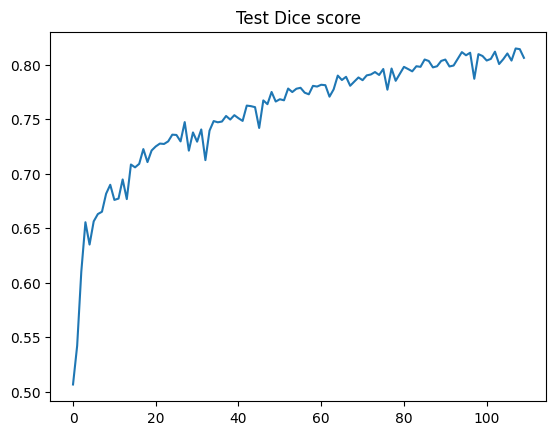

In [ ]:
plt.plot(metric_values2)
# plt.ylabel('Validation Dice score')
plt.title('Test Dice score')
plt.savefig('fig.png')

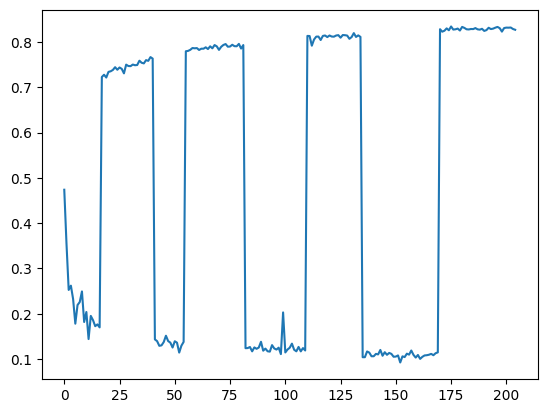

In [ ]:
plt.plot(metric_values)

In [ ]:
!lscpu

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:                        3
CPU MHz:                         2000.202
BogoMIPS:                        4000.40
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cac

In [ ]:
np.save('/content/drive/MyDrive/PARSE/PAS/weights/swin30_dice_val2.npy', metric_values)
np.save('/content/drive/MyDrive/PARSE/PAS/weights/swin30_epoch_loss2.npy', epoch_loss_values)

### Evaluation

### Swin Inference

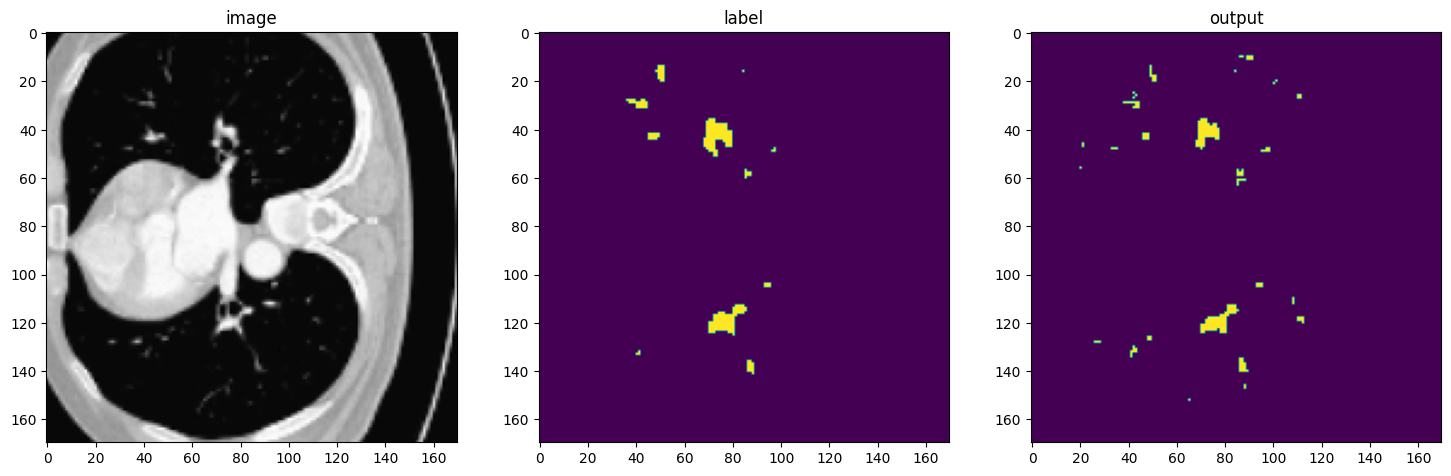

In [ ]:
case_num = 4
sl = 85
root_dir = '/content/drive/MyDrive/PARSE/PAS/weights/max'
model.load_state_dict(torch.load(os.path.join(root_dir, "swin_fusion_od2.pth")))
model.eval()
with torch.no_grad():
    # img_name = os.path.split(val_ds[case_num]['image'])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 2, model, overlap=0.25
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, sl], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, sl])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, sl]
    )
    plt.show()

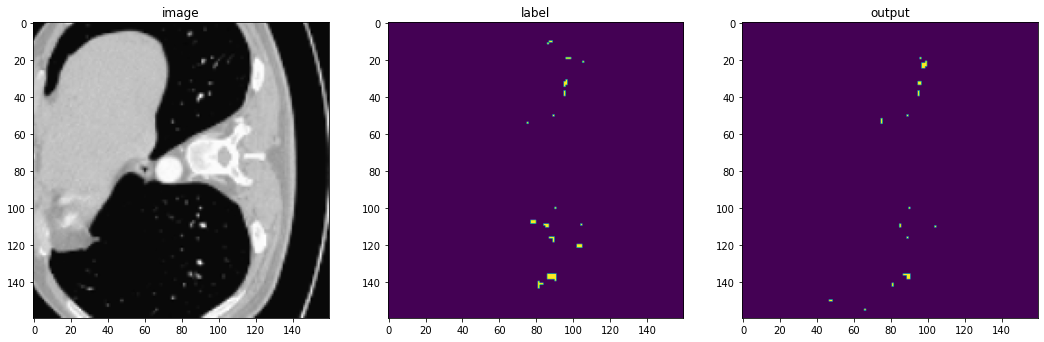

In [ ]:
case_num = 4
sl = 40
# root_dir = '/content/drive/MyDrive/PARSE/PAS/weights'
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_swin.pth")))
model.eval()
with torch.no_grad():
    # img_name = os.path.split(val_ds[case_num]['image'])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 2, model, overlap=0.25
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, sl], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, sl])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, sl]
    )
    plt.show()